In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Discrete sampling
In the last problem of the first session we sampled with given probabilities using prefix sums and binary search. The sampling code is the bottleneck of the whole process, its running times is 3 times higher than the code for uniform probabilities, and the difference would only increase for larger number of outcomes. In the next two problems we discuss two simple, but powerful techniques one can use to sample in time $O(1)$.

**Problem 2a.** Consider the problem of sampling with known probabilities $p_1,\ldots,p_d$. Suppose that you have a black-box that samples with probabilities $q_1,\ldots,q_d$ that are close to $p_1,\ldots,p_d$, say
$$ \forall_{i=1,\ldots,n} p_i \le (1+\varepsilon)q_i.$$

* How can you use this black-box to sample with probabilities $p_1,\ldots,p_d$? It is expected, that the running time of the algorithm would be non-deterministic.
* Prove that your algorithm is correct.
* Implement the algorithm and use it to give a faster implementation for **Problem 1c**.

$$q_i = 1/d$$

$$\frac{\bar{p_i}}{q_i} = \frac{p_i}{q_i * (1 + \epsilon)} = \frac{p_i}{p_{max}}$$

In [2]:
import random


N = 100000
stats = np.loadtxt('../lab1/us_births_69_88.csv', skiprows=1, delimiter=',', dtype=int)


# an example of a closure in Python
# Python functions are first class objects (e.g. can be returned in a function)
def create_sample(counts):
    max_count = np.max(counts)
    size = counts.shape[0]
    
    def sample():
        day = random.randint(0, size - 1)
        if random.randint(1, max_count) <= counts[day]:
            return day
        return sample()
    return sample


def emp_dates(size, sample):
    s = set()
    for k in range(size + 1):
        day = sample()
        if day in s:
            return k + 1
        else:
            s.add(day)

In [3]:
%%time


size = stats.shape[0]
sample = create_sample(stats[:, 2])
emp_sample = [emp_dates(size, sample) for _ in range(N)]

CPU times: user 8.76 s, sys: 60.1 ms, total: 8.82 s
Wall time: 8.9 s


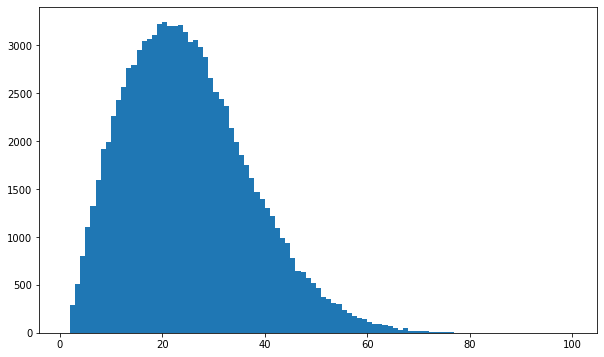

Couple first most likely values: [20, 19, 23, 21, 22, 24, 18, 17, 26, 16]
Average value: 24.60559
Average value using numpy: 24.60559


In [4]:
plt.figure(figsize=(10, 6))
plt.hist(emp_sample, bins=range(1, 101))
plt.show()

# calcultating most probable values in pure Python
k_counts = sorted(list(set(emp_sample)), key=emp_sample.count, reverse=True)

# numpy version
vals, counts = np.unique(emp_sample, return_counts=True)
k_counts_numpy = vals[np.argsort(counts)][::-1]

# check numpy results
# for all values there may be problems with ties so check only first 10 (still might fail rarely)
assert (k_counts_numpy[:10] == k_counts[:10]).all()

print('Couple first most likely values: {}'.format(k_counts[:10]))

print('Average value: {}'.format(float(sum(emp_sample)) / len(emp_sample)))
print('Average value using numpy: {}'.format(np.mean(emp_sample)))

**Problem 2b.** One of the reasons this implementation is not significantly faster than the one in **Problem 1c** , apart from $d$ being rather small, is that we are using Python's interpreter a bit too much, and Python is slow. One way around this is usually to use a library function - **searchsorted** is much faster than an equivalent code implemented in pure Python. But even if the functionality you need is not implemented in a lower level language as
a library function, there is still hope. You can try to implement it using optimized array algebra, for example using **numpy**. In this problem, your task is to rewrite the previous algorithm, so that the amount of *looping* is reduced to a minimum necessary. In particular, you should create a *vectorized* version of random dates generation (in bulk), while the actual search for duplicates remains a loop with a **set**. Here are some useful tips:
   * You can perform arithmetic, comparisons, etc. on **numpy** arrays. 
   * You can generate whole **numpy** arrays of random numbers at once.
   * You can even perform parallel look-up like in the example below.

In [5]:
X = np.array([10,3,7])
I = np.array([1,1,2,2])
print(X[I])
X = np.array([[1,2],[3,4]])
I = np.array([0,0,1])
J = np.array([1,0,1])
print(X[I,J])

[3 3 7 7]
[2 1 4]


In [6]:
def create_sample_vec(counts, sample_size):
    max_count = np.max(counts)
    size = counts.shape[0]
    
    sample_size = int(sample_size * 1.2)  # just to be sure we create enough samples
    
    # what we perform here is basically a vectorized version of sample() function
    # used in 2a, but instead of recursively calling it we do not return anything
    days = np.random.randint(0, size, sample_size)
    ok = np.random.randint(1, max_count + 1, sample_size) <= counts[days, 2]
    days = days[ok]
    return days


# very similar to emp_dates() in 2a, but we calculate whole emp_sample here
def emp_dates_vec(sample):
    dates = []
    s = set()
    k = 0
    for day in sample:
        k += 1
        if day in s:
            dates.append(k)
            k = 0
            s.clear()
        else:
            s.add(day)
    return dates

In [7]:
%%time

# we obtain around 10 fold speedup in computation time using the vectorized version


days = create_sample_vec(stats, N * 25)  # why 25 here? What is the average value of first repeats?
emp_sample = emp_dates_vec(days)
print('Size of sample: {}'.format(len(emp_sample)))

Size of sample: 108467
CPU times: user 730 ms, sys: 27.9 ms, total: 758 ms
Wall time: 762 ms


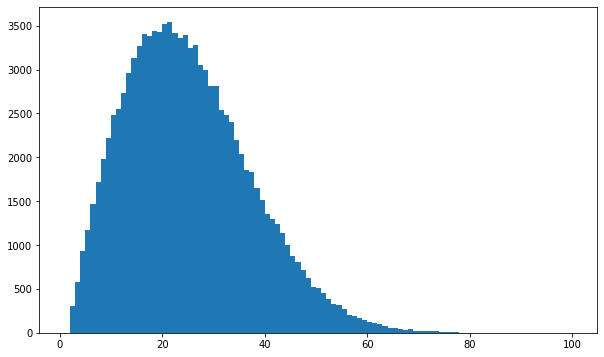

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(emp_sample, bins=range(1, 101))
plt.show()

**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $M=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.

**Problem 2d.** Show that the frequency histogram for empirical birthday frequencies can actually be computed exactly, and implement your idea. To this end, design a recurence relation using conditional probabilities and use dynamic programming.